# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Cluster brain structures into circuits by PMI-weighted co-occurrences with mental function terms.
2. Identify the mental function terms most highly associated to each circuit over a range of list lengths.
3. Select the list length for each circuit that maximizes word-structure classification performance. 
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import utilities, ontology

In [2]:
suffix = "nn"

## Brain activation coordinates

In [3]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Terms for mental functions

In [4]:
version = 190325
dtm_bin = utilities.load_doc_term_matrix(version=version, binarize=True)

In [5]:
lexicon = utilities.load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns)))
len(lexicon)

1683

In [6]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=1683


In [7]:
# Total occurrences of terms in the lexicon
dtm = utilities.load_doc_term_matrix(version=version, binarize=False)
dtm = dtm[lexicon]
np.sum(dtm.values)

4831488

## Document splits

In [8]:
train, val = [[int(pmid.strip()) 
               for pmid in open("../data/splits/{}.txt".format(split))] 
                    for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Link structures to functions

Links are computed as PMI-weighted co-occurrences across the training set

In [9]:
stm = ontology.load_stm(act_bin.loc[train], dtm_bin.loc[train])
print("Structure N={}, Term N={}".format(stm.shape[0], stm.shape[1]))

Structure N=118, Term N=1634


### Terms most strongly linked to the left amygdala

In [10]:
stm.loc["left_amygdala"].sort_values(ascending=False)[:10]

olfactory_stimulus_transduction      4.286718
auditory_system_function             3.082745
letter_naming_task                   2.900424
eye_puff                             2.494958
face_identification_task             2.440891
pavlovian_conditioning_task          2.035426
emotion_expression_identification    2.018034
waisinformation                      2.018034
social_norm_processing_task          1.984133
offensive_aggression                 1.951343
Name: left_amygdala, dtype: float64

### Structures most strongly linked to *face_identification_task*

In [11]:
stm["face_identification_task"].sort_values(ascending=False)[:10]

right_parahippocampal_gyrus_anterior_division    2.540766
left_frontal_medial_cortex                       2.467574
right_amygdala                                   2.465049
left_parahippocampal_gyrus_anterior_division     2.448795
right_frontal_medial_cortex                      2.442356
left_amygdala                                    2.440891
right_hippocampus                                2.129478
left_temporal_pole                               2.026462
right_temporal_pole                              2.001289
left_cingulate_gyrus_anterior_division           1.582475
Name: face_identification_task, dtype: float64

# Generate the ontology

## 1. Cluster brain structures by functions

In [12]:
import os
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr

In [13]:
n_circuits = range(2, 51) # Range over which ROC-AUC becomes asymptotic
list_lens = range(5, 51) # Same range as RDoC and the DSM

In [14]:
for k in n_circuits:
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    if not os.path.isfile(circuit_file):
        kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)  
        kmeans.fit(stm)
        clust = pd.DataFrame({"STRUCTURE": act_bin.columns, 
                              "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
        clust = clust.sort_values(["CLUSTER", "STRUCTURE"])
        clust.to_csv(circuit_file, index=None)

## 2. Identify associated terms for mental functions

In [15]:
for k in n_circuits:
    circuit_file = "circuits/circuits_k{:02d}.csv".format(k)
    clust = pd.read_csv(circuit_file, index_col=None)
    list_file = "lists/lists_k{:02d}.csv".format(k)
    if not os.path.isfile(list_file):
        lists = pd.DataFrame()
        for i in range(k):
            structures = list(clust.loc[clust["CLUSTER"] == i+1, "STRUCTURE"])
            centroid = np.mean(act_bin.loc[train, structures], axis=1)
            R = pd.Series([pointbiserialr(dtm_bin.loc[train, word], centroid)[0] 
                           for word in dtm_bin.columns], index=dtm_bin.columns)
            R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
            R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                              "TOKEN": R.index, "R": R.values})
            lists = lists.append(R)
        lists.to_csv(list_file, index=None)

## 3. Select number of words per domain

Word list lengths were selected by mean ROC-AUC of forward and reverse classifiers for each circuit. The number of circuits will be selected across values of k using the lists of optimized length, this time training classifiers that use all the circuits at that k. All classifiers were optimized over a grid search for regularization strength, penalty, and intercept.

## 4. Select optimal number of domains

### Circuit-level features

In [16]:
import torch
from sklearn.preprocessing import binarize
from prediction.neural_network.prediction import Net

In [17]:
directions = ["forward", "reverse"]

In [18]:
fits = {}
for d in directions:
    fits[d] = {}
    for k in n_circuits:
        state_dict = torch.load("neural_network/sherlock/fits/{}_k{:02d}.pt".format(d, k))
        hyperparams = pd.read_csv("neural_network/data/params_data-driven_k{:02d}_{}.csv".format(k, d), header=None, index_col=0)
        h = {str(label): float(value) for label, value in hyperparams.iterrows()}
        layers = list(state_dict.keys())
        n_input = state_dict[layers[0]].shape[1]
        n_output = state_dict[layers[-2]].shape[0]
        fits[d][k] = Net(n_input=n_input, n_output=n_output, 
                         n_hid=int(h["n_hid"]), p_dropout=h["p_dropout"])
        fits[d][k].load_state_dict(state_dict)

In [19]:
features = {k: {} for k in n_circuits}
for k in n_circuits:
    domains = range(1, k+1)
    lists, circuits = ontology.load_ontology(k, suffix="_" + suffix)
    function_features = pd.DataFrame(index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(index=act_bin.index, columns=domains)
    for i in domains:
        functions = lists.loc[lists["CLUSTER"] == i, "TOKEN"]
        function_features[i] = dtm_bin[functions].sum(axis=1)
        structures = circuits.loc[circuits["CLUSTER"] == i, "STRUCTURE"]
        structure_features[i] = act_bin[structures].sum(axis=1)
    function_features = pd.DataFrame(utilities.doc_mean_thres(function_features), 
                                     index=dtm_bin.index, columns=domains)
    structure_features = pd.DataFrame(binarize(structure_features), 
                                     index=act_bin.index, columns=domains)
    features[k]["function"] = function_features
    features[k]["structure"] = structure_features

### Area under the receiver operating characteristic curve (ROC-AUC)

In [20]:
import math
from sklearn.metrics import roc_auc_score
from matplotlib import rcParams
%matplotlib inline

In [42]:
rcParams["axes.linewidth"] = 1.5

In [22]:
stats = {}

In [23]:
stats["scores"] = ontology.compute_eval_scores(suffix, roc_auc_score, directions, 
                                               n_circuits, features, fits, val)

In [24]:
stats["boot"] = ontology.compute_eval_boot(suffix, roc_auc_score, directions, 
                                           n_circuits, features, fits, val, n_iter=1000)

In [25]:
stats["null"] = ontology.compute_eval_null(suffix, roc_auc_score, directions, 
                                           n_circuits, features, fits, val, n_iter=1000)

In [26]:
directions += ["mean"]
shapes = [">", "<", "D"]
op_k = 6

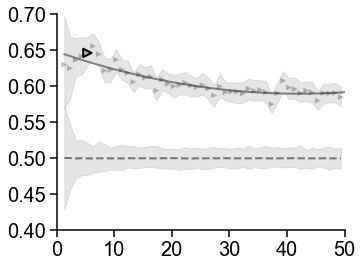

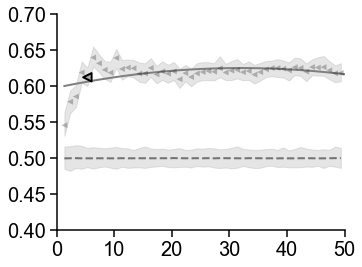

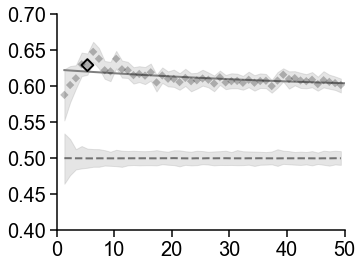

In [43]:
for direction, shape in zip(directions, shapes):
    ontology.plot_scores_by_k(direction, n_circuits, stats, clf="nn",
                              shape=shape, interval=0.999, op_k=op_k, poly_order=2,
                              ylim=[0.45,0.7], yticks=np.arange(0.4,0.75,0.05))

# Name the domains

## Load the lists and circuits of the selected <i>k</i>

In [28]:
lists, circuits = ontology.load_ontology(op_k, suffix="_" + suffix)

## Select the term with highest degree centrality

Also ensure that names are unique across domains in the clustering solution

In [29]:
k2terms = {i: list(set(lists.loc[lists["CLUSTER"] == i+1, "TOKEN"])) for i in range(op_k)}
k2name = {i+1: "" for i in range(op_k)}
names, degs = [""]*op_k, [0]*op_k
while "" in names:
    for i in range(op_k):
        degrees = ontology.term_degree_centrality(i+1, lists, dtm_bin, dtm_bin.index)
        degrees = degrees.loc[k2terms[i]].sort_values(ascending=False)
        name = degrees.index[0].upper()
        if name not in names:
            names[i] = name
            degs[i] = max(degrees)
            k2name[i+1] = name
        elif name in names:
            name_idx = names.index(name)
            if degs[name_idx] > degs[i]:
                k2terms[i] = [term for term in k2terms[i] if term != name.lower()]
names

['VISION', 'LANGUAGE', 'MANIPULATION', 'REWARD', 'COGNITIVE', 'MEMORY']

## Convert to noun form

Cannot use WordNet because it omits variants of psychological terms

In [30]:
title_df = pd.read_csv("../lexicon/labels_cogneuro.csv", index_col=None, header=0)
term2title = {term.upper(): title.upper().replace(" ", "_") for term, title in zip(title_df["TERM"], title_df["TITLE"])}

In [31]:
k2name = {k: ontology.nounify(name, term2title) for k, name in k2name.items()}
names = [ontology.nounify(name, term2title) for name in names]
names

['VISION', 'LANGUAGE', 'MANIPULATION', 'REWARD', 'COGNITION', 'MEMORY']

## Sort by predetermined semantic ordering

In [32]:
order = [6,4,5,1,3,2]
k2order = {k: order.index(k)+1 for k in range(1,op_k+1)}
names = [k2name[k] for k in order]
names

['MEMORY', 'REWARD', 'COGNITION', 'VISION', 'MANIPULATION', 'LANGUAGE']

## Export ontology with domain names

### Function term lists

In [33]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "TOKEN", "R", "ROC_AUC"]
lists["ORDER"] = [k2order[k] for k in lists["CLUSTER"]]
lists["DOMAIN"] = [k2name[k] for k in lists["CLUSTER"]]
lists = lists.sort_values(["ORDER", "R"], ascending=[True, False])
lists = lists[columns]
lists.to_csv("lists/lists_data-driven_" + suffix + ".csv", index=None)
lists.head()

,ORDER,CLUSTER,DOMAIN,TOKEN,R,ROC_AUC
68,1,6,MEMORY,memory,0.199004,0.647796
69,1,6,MEMORY,episodic_memory,0.174621,0.647796
70,1,6,MEMORY,declarative_memory,0.172933,0.647796
71,1,6,MEMORY,recognition_memory,0.162350,0.647796
72,1,6,MEMORY,remembering,0.157813,0.647796


### Brain circuits

In [34]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "STRUCTURE"]
circuits["ORDER"] = [k2order[k] for k in circuits["CLUSTER"]]
circuits["DOMAIN"] = [k2name[k] for k in circuits["CLUSTER"]]
circuits = circuits.sort_values(["ORDER", "STRUCTURE"])
circuits = circuits[columns]
circuits.head()

,ORDER,CLUSTER,DOMAIN,STRUCTURE
104,1,6,MEMORY,left_amygdala
105,1,6,MEMORY,left_hippocampus
106,1,6,MEMORY,left_inferior_temporal_gyrus_anterior_division
107,1,6,MEMORY,left_parahippocampal_gyrus_anterior_division
108,1,6,MEMORY,left_parahippocampal_gyrus_posterior_division


In [35]:
circuit_mat = pd.DataFrame(0.0, index=act_bin.columns, columns=names)
for name in names:
    structures = circuits.loc[circuits["DOMAIN"] == name, "STRUCTURE"]
    for structure in structures:
        circuit_mat.loc[structure, name] = 1.0
circuit_mat.to_csv("circuits/clusters_data-driven_" + suffix + ".csv")
circuit_mat.head()

,MEMORY,REWARD,COGNITION,VISION,MANIPULATION,LANGUAGE
left_frontal_pole,0.0,0.0,1.0,0.0,0.0,0.0
left_insular_cortex,0.0,0.0,1.0,0.0,0.0,0.0
left_superior_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0
left_middle_frontal_gyrus,0.0,0.0,0.0,0.0,1.0,0.0
left_inferior_frontal_gyrus_pars_triangularis,0.0,0.0,1.0,0.0,0.0,0.0


In [36]:
scores = utilities.score_lists(lists, dtm_bin, label_var="DOMAIN").loc[act_bin.index]
pmi = ontology.compute_cooccurrences(act_bin, scores, positive=True)
pmi = ontology.threshold_pmi_by_circuits(pmi, circuits)
pmi.to_csv("circuits/circuits_data-driven_" + suffix + ".csv")
pmi.head()

,MEMORY,REWARD,COGNITION,VISION,MANIPULATION,LANGUAGE
left_frontal_pole,0.0,0.0,0.055314,0.0,0.000000,0.0
left_insular_cortex,0.0,0.0,0.035942,0.0,0.000000,0.0
left_superior_frontal_gyrus,0.0,0.0,0.000000,0.0,0.072495,0.0
left_middle_frontal_gyrus,0.0,0.0,0.000000,0.0,0.077672,0.0
left_inferior_frontal_gyrus_pars_triangularis,0.0,0.0,0.029363,0.0,0.000000,0.0


# Visualize the term lists

In [37]:
from style import style
%matplotlib inline

MEMORY


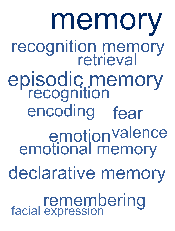

REWARD


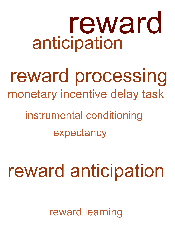

COGNITION


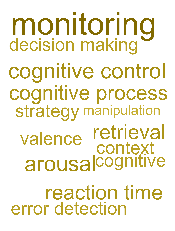

VISION


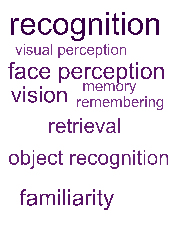

MANIPULATION


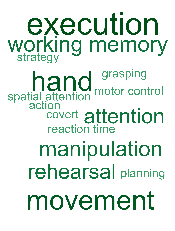

LANGUAGE


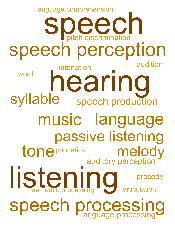

In [38]:
ontology.plot_wordclouds("data-driven", names, lists, metric="R", 
                         suffix="_nn", palette=style.palettes["data-driven"],
                         height=350, width=260, min_font_size=0, max_font_size=50,
                         brightness_offset=0.15, darkness_offset=-0.35, n_offsets=25)

# Visualize the circuits

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


MEMORY               Min: 0.0000  Mean: 0.0334  Max: 0.3838


/anaconda3/envs/ontol/lib/python3.6/site-packages/nilearn/plotting/displays.py:1582: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


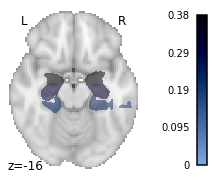

REWARD               Min: 0.0000  Mean: 0.0472  Max: 0.6756


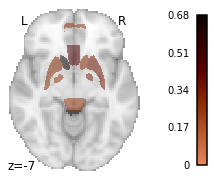

COGNITION            Min: 0.0000  Mean: 0.0072  Max: 0.0785


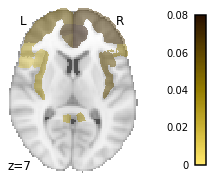

VISION               Min: 0.0000  Mean: 0.0257  Max: 0.2105


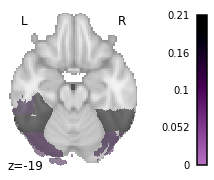

MANIPULATION         Min: 0.0000  Mean: 0.0259  Max: 0.1881


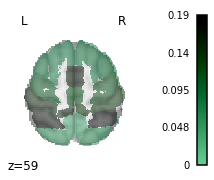

LANGUAGE             Min: 0.0000  Mean: 0.0408  Max: 0.4010


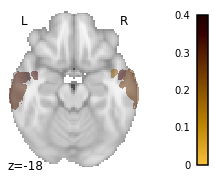

In [39]:
atlas = utilities.load_atlas()
path = "figures/circuits/data-driven_" + suffix
cmaps = style.colormaps["data-driven"]
vmaxs = [round(v, 2) for v in pmi.max()]
for plane, verbose in zip(["z", "x", "y"], [True, False, False]):
    utilities.map_plane(pmi, atlas, path, suffix="_"+plane, cmaps=cmaps, vmaxs=vmaxs,
                        plane=plane, cbar=True, verbose=verbose, print_fig=verbose)